# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strengths
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from comp411.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'comp411/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **comp411/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file comp411/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from comp411.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.345157
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$    
In previous cell, there is no learning activities. The process is just calculation *negative log-likelihood*. When our dataset which is CIFAR-10 is considered, result of the calculation should be approximated *-log(0.1)* becuse there are 10 classes in our set.

In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from comp411.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularizations
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.494526 analytic: -0.494526, relative error: 2.550862e-08
numerical: 0.025351 analytic: 0.025351, relative error: 1.910895e-06
numerical: -2.566406 analytic: -2.566406, relative error: 1.005643e-08
numerical: -2.062791 analytic: -2.062791, relative error: 5.902985e-09
numerical: 1.495146 analytic: 1.495146, relative error: 4.822421e-08
numerical: -2.070298 analytic: -2.070298, relative error: 2.572611e-09
numerical: -1.985367 analytic: -1.985367, relative error: 3.702465e-09
numerical: -0.963640 analytic: -0.963640, relative error: 4.322832e-08
numerical: 3.801020 analytic: 3.801020, relative error: 7.477204e-09
numerical: 0.461377 analytic: 0.461377, relative error: 3.862236e-08
numerical: 5.645871 analytic: 0.645877, relative error: 7.946909e-01
numerical: 4.810191 analytic: -0.189812, relative error: 1.000000e+00
numerical: 2.972750 analytic: -2.027240, relative error: 1.000000e+00
numerical: 4.589749 analytic: -0.410204, relative error: 1.000000e+00
numerical: 6.298627

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from comp411.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.345157e+00 computed in 0.093479s
vectorized loss: 2.345157e+00 computed in 0.006028s
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
'''
It is a requirement to define parameters for optimization.
There is no instruction to define L2 and L1 parameters into train() method.
'''
from comp411.classifiers import Softmax
import inspect 
  
# use signature() 
print(inspect.signature(Softmax.train)) 

(self, X, y, learning_rate=0.001, reg=1e-05, reg_l1=None, num_iters=100, batch_size=200, verbose=False)


In [7]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from comp411.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be similar to the validation that you did for the SVM; save      #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-7]
regularization_strengths_l2 = [2.5e4, 5e4]
regularization_strengths_l1 = [0, 2.5e2, 5e2]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg_l2 in regularization_strengths_l2:
        for reg_l1 in regularization_strengths_l1:
            our_softmax = Softmax()
            our_softmax.train(X_train, y_train, learning_rate = lr,
                          reg=reg_l2, reg_l1=reg_l1, num_iters=3000, verbose=True)
            
            # Training
            train_accuracy = np.mean(y_train == our_softmax.predict(X_train))
        
            # Validation
            val_accuracy = np.mean(y_val == our_softmax.predict(X_val))
        
            # store all results
            results[(lr, reg_l2, reg_l1)] = (train_accuracy, val_accuracy)
            if val_accuracy > best_val:
                best_val = val_accuracy
                best_softmax = our_softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, rg_l2, rg_l1 in sorted(results):
    train_accuracy, val_accuracy = results[(lr, rg_l2,rg_l1)]
    print('lr %e rg_l2 %e rg_l1 %e train accuracy: %f val accuracy: %f' % (
                lr, rg_l2, rg_l1, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 3000: loss 772.047157
iteration 100 / 3000: loss 746.825067
iteration 200 / 3000: loss 723.932865
iteration 300 / 3000: loss 702.786998
iteration 400 / 3000: loss 682.514146
iteration 500 / 3000: loss 663.731213
iteration 600 / 3000: loss 645.688548
iteration 700 / 3000: loss 628.786702
iteration 800 / 3000: loss 612.811787
iteration 900 / 3000: loss 597.671124
iteration 1000 / 3000: loss 583.201048
iteration 1100 / 3000: loss 569.603077
iteration 1200 / 3000: loss 556.208004
iteration 1300 / 3000: loss 543.855682
iteration 1400 / 3000: loss 531.780839
iteration 1500 / 3000: loss 520.382357
iteration 1600 / 3000: loss 509.276490
iteration 1700 / 3000: loss 498.906850
iteration 1800 / 3000: loss 488.720720
iteration 1900 / 3000: loss 479.279855
iteration 2000 / 3000: loss 469.728905
iteration 2100 / 3000: loss 460.963709
iteration 2200 / 3000: loss 452.017627
iteration 2300 / 3000: loss 443.891268
iteration 2400 / 3000: loss 435.984061
iteration 2500 / 3000: loss 428.23391

iteration 100 / 3000: loss 2376.502655
iteration 200 / 3000: loss 1212.780470
iteration 300 / 3000: loss 816.406566
iteration 400 / 3000: loss 616.467253
iteration 500 / 3000: loss 497.055990
iteration 600 / 3000: loss 416.796205
iteration 700 / 3000: loss 359.626584
iteration 800 / 3000: loss 316.570407
iteration 900 / 3000: loss 283.603793
iteration 1000 / 3000: loss 257.240178
iteration 1100 / 3000: loss 235.784412
iteration 1200 / 3000: loss 217.600474
iteration 1300 / 3000: loss 202.511798
iteration 1400 / 3000: loss 189.588876
iteration 1500 / 3000: loss 178.393196
iteration 1600 / 3000: loss 168.933261
iteration 1700 / 3000: loss 160.095235
iteration 1800 / 3000: loss 152.531688
iteration 1900 / 3000: loss 145.759281
iteration 2000 / 3000: loss 139.840452
iteration 2100 / 3000: loss 134.638302
iteration 2200 / 3000: loss 129.505865
iteration 2300 / 3000: loss 125.256229
iteration 2400 / 3000: loss 120.841973
iteration 2500 / 3000: loss 117.294898
iteration 2600 / 3000: loss 113.

In [8]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.396000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$   <span style='color:green '> **True** </span>   
$\color{blue}{\textit Your Explanation:}$  
Softmax allows to calculate individual loss values in each data point for every class and score of correct class is maximized during training. SVM just calculates loss in locally and it is based on distance comparison and it is updated when a new datapoint is added to training set.

**Inline Question 3** 

Comment on the effects of unifying L1 and L2 losses while using Elastic Net Regularization Loss? Did L2 loss achieve better when used alone or not?

$\color{blue}{\textit Your Comment:}$  
When L1 and L2 regularizers are compared, L1 (Lasso) provide sparser and more interpretable models than L2. L2 (Ridge) creates more complex one analytical solution, so it is computationally efficient. If Elastic Net Regularization (combination of L1 & L2) is preferred, the regularizer can be more robust around outliers and sparser than L2. Elastic Net Regularization is more computationally efficient and able to handle complex problems than L1. Their visualization is also presented below [from the source](https://medium.com/analytics-vidhya/regularization-with-elastic-net-dbfea56667ed):

![lasso-ridge-elastic](https://miro.medium.com/max/1190/1*FeEcaN2Rd343mPNA05sQgQ.png)

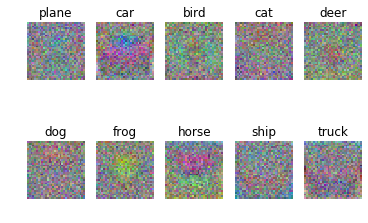

In [9]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])